# Machine Learning
### Common feature scaling or normalization methods
#### Standard scaler, robust scaler, and minmax scaler
We should **normalize** the numerical features (except binary features) before feeding them into machine learning models. 
Some points on normalization (scaling):
- Always fit scalers on training data only, then transform train/test separately to avoid **data leakage**.
- Don’t scale:
    - **Binary** features (unless intentional)
    - **One-hot encoded** features (they’re already normalized)
- For **tree-based** models (Random Forest, XGBoost), scaling is usually unnecessary—they’re **scale-invariant**.

<hr>

Here, we review the three common **normalization** methods, which  we may  call them:
- **Standard scaler**
- **Minmax scaler**
- **Robust scaler**

The **standard normalization** called **standard scaler** for a feature vector $\boldsymbol{x}=[x_1,x_2,...,x_n]$ having $n$ samples transforms each sample $x_i$ by:
<br> $\large x_i\leftarrow\frac{x_i-\mu}{\sigma}$
<br>where $\mu$ is the sample mean, and $\sigma^2$ is the sample variance of the $n$ samples.
<br> **Hint 1:** The standard scaler is not robust to *outliers*. 
<hr>

The **minmax scaler** scales features to a fixed range, typically [0, 1]. Specifically:
<br> $\large x_i\leftarrow \frac{x_i-x_{min}}{x_{max}-x_{min}}$
<br> Where $x_{min}$ in the minimum possible value for the feature, and $x_{max}$ is the maximum possible value for the feature.
<br>When to use the minmax scaler:
- Neural networks (often prefer [0,1] or [-1,1])
- When you know the theoretical min/max (e.g., pixel intensities: 0–255)
- Data is bounded and no significant **outliers**.

**Hint 2:** We may scale features to the interval $[a,b]$ instead of $[0,1]$ by:
<br> $\large x_i\leftarrow a+(b-a)\cdot \frac{x_i-x_{min}}{x_{max}-x_{min}}$
<hr>

The **robust scaler** scales data using statistics robust to outliers: **median** and **IQR**. Accordingly:
<br>$\large x_i\leftarrow \frac{x_i-median}{IQR}=\frac{x_i-Q_2}{Q_3-Q_1}$
<br>Where:
- $Q_1$ = 25th percentile  
- $Q_2$ = 50th percentile (median)  
- $Q_3$ = 75th percentile  
- $IQR = Q3−Q1$

**Reminder:** 
- $Q_2$ is the median of the samples, which divides the increasingly sorted samples into two parts.
- The median of the lower part is $Q_1$.
- and the median of the upper part is $Q_3$.
- **Interquartile Range** (**IQR**) = $Q_3 – Q_1$, which is the middle 50% of the samples.

**Median:** We sort the samples increasingly or decreasingly. Then, the middle value is the median, if the number of samples is odd; otherwise, the average of the two middle values is the median.

**Hint 3:** Since the median is robust to outliers, the robust scaler is robust to **outliers**.
<br> When yo use robusrt scaler:
- Data contains outliers.
- Distribution is skewed.
    - Skewed data means the distribution of values is not symmetric.
- You want to preserve the structure of the majority of data.

<hr>

In the following, we implement the three mentioned normalziation methods or scalers from scratch. Then, we use them with a simple example having a single outlier. Later, we download the **Iris dataset**, and apply the scalers to it. Finally, we display a 2D plot of the scaled iris data points.

<hr>

https://github.com/ostad-ai/Machine-Learning
<br> Explanation: https://www.pinterest.com/HamedShahHosseini/Machine-Learning/

In [1]:
# Import required modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
class StandardScaler:
    """
    Standardize features by removing the mean and scaling to unit variance.
    The transformation is:
        X_scaled = (X - mean) / standard_deviation
    Uses sample standard deviation (with ddof=1) for unbiased variance estimation.
    """
    
    def __init__(self):
        """
        Initialize scaler attributes.
        These will be set during fit().
        """
        self.mean_ = None      # Mean of each feature (column)
        self.scale_ = None     # Standard deviation of each feature (sample std, ddof=1)
        self.is_fitted_ = False  # Flag to check if fit() has been called

    def fit(self, X):
        """
        Compute the mean and standard deviation for each feature from the data.
        
        Parameters:
            X : array-like of shape (n_samples, n_features)
                The training data used to compute scaling statistics.
        
        Returns:
            self : object
                Fitted scaler instance.
        """
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("Input X must be a 2D array (samples x features).")
        
        # Compute mean for each feature (column-wise)
        self.mean_ = np.mean(X, axis=0)
        
        # Compute sample standard deviation (ddof=1 for unbiased estimator)
        self.scale_ = np.std(X, axis=0, ddof=1)
        
        # Handle constant features (std = 0) to avoid division by zero
        # If std is 0, set scale to 1 so transformed value = x - mean (which will be 0)
        self.scale_ = np.where(self.scale_ == 0, 1.0, self.scale_)
        
        self.is_fitted_ = True
        return self

    def transform(self, X):
        """
        Standardize the input data using the fitted mean and standard deviation.
        
        Parameters:
            X : array-like of shape (n_samples, n_features)
                Data to transform.
                
        Returns:
            X_scaled : ndarray of shape (n_samples, n_features)
                Transformed data with zero mean and unit variance (per feature).
        """
        if not self.is_fitted_:
            raise ValueError("Scaler has not been fitted. Call fit() first.")
        
        X = np.asarray(X)
        if X.shape[1] != self.mean_.shape[0]:
            raise ValueError(
                f"Number of features in X ({X.shape[1]}) does not match "
                f"number of features in fitted data ({self.mean_.shape[0]})."
            )
        
        # Apply standardization: (X - mean) / std
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        """
        Fit to data, then transform it.
        
        Parameters:
            X : array-like of shape (n_samples, n_features)
            
        Returns:
            X_scaled : ndarray
        """
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        """
        Undo the standardization to recover original scale.
        
        Parameters:
            X_scaled : array-like of shape (n_samples, n_features)
                Standardized data.
                
        Returns:
            X_original : ndarray
                Data in original scale.
        """
        if not self.is_fitted_:
            raise ValueError("Scaler has not been fitted.")
        return X_scaled * self.scale_ + self.mean_

In [3]:
class MinMaxScaler:
    """
    Scale features to a fixed range, typically [0, 1].
    Transforms each feature independently using:
        X_scaled = (X - X_min) / (X_max - X_min)
    Then optionally maps to [feature_range[0], feature_range[1]].
    """
    
    def __init__(self, feature_range=(0, 1)):
        """
        Initialize the scaler.
        Parameters:
            feature_range: tuple (min, max) for output range. Default is (0, 1).
        """
        self.feature_range = feature_range
        self.data_min_ = None   # Minimum of each feature
        self.data_max_ = None   # Maximum of each feature
        self.scale_ = None      # Range (max - min) for each feature
        self.is_fitted_ = False

    def fit(self, X):
        """
        Compute min and max for each feature from the training data.
        Parameters:
            X: array-like of shape (n_samples, n_features)
        Returns:
            self
        """
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("Input X must be a 2D array.")
        
        self.data_min_ = np.min(X, axis=0)
        self.data_max_ = np.max(X, axis=0)
        self.scale_ = self.data_max_ - self.data_min_
        
        # Avoid division by zero for constant features
        self.scale_ = np.where(self.scale_ == 0, 1.0, self.scale_)
        
        self.is_fitted_ = True
        return self

    def transform(self, X):
        """
        Scale the data using the fitted min and max.
        Parameters:
            X: array-like of shape (n_samples, n_features)
        Returns:
            X_scaled: scaled array of same shape
        """
        if not self.is_fitted_:
            raise ValueError("Scaler has not been fitted. Call fit() first.")
        X = np.asarray(X)
        if X.shape[1] != self.data_min_.shape[0]:
            raise ValueError("Number of features in X does not match fitted data.")
        
        # Scale to [0, 1]
        X_std = (X - self.data_min_) / self.scale_
        
        # Scale to desired feature range [a, b]
        a, b = self.feature_range
        X_scaled = a + X_std * (b - a)
        return X_scaled

    def fit_transform(self, X):
        """Fit to data, then transform it."""
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        """
        Undo the scaling to recover original data.
        """
        if not self.is_fitted_:
            raise ValueError("Scaler has not been fitted.")
        a, b = self.feature_range
        X_std = (X_scaled - a) / (b - a)
        return X_std * self.scale_ + self.data_min_

In [4]:
class RobustScaler:
    """
    Scale features using statistics robust to outliers:
        X_scaled = (X - median) / IQR
    where IQR = Q3 - Q1 (interquartile range).
    """
    
    def __init__(self):
        """
        Initialize the scaler.
        No parameters needed.
        """
        self.center_ = None   # Median of each feature
        self.scale_ = None    # IQR (Q3 - Q1) of each feature
        self.is_fitted_ = False

    def fit(self, X):
        """
        Compute median and IQR for each feature.
        Parameters:
            X: array-like of shape (n_samples, n_features)
        Returns:
            self
        """
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("Input X must be a 2D array.")
        
        # Median (50th percentile)
        self.center_ = np.median(X, axis=0)
        
        # First (25%) and third (75%) quartiles
        q25 = np.percentile(X, 25, axis=0)
        q75 = np.percentile(X, 75, axis=0)
        self.scale_ = q75 - q25  # IQR
        
        # Avoid division by zero for constant features
        self.scale_ = np.where(self.scale_ == 0, 1.0, self.scale_)
        
        self.is_fitted_ = True
        return self

    def transform(self, X):
        """
        Scale the data using fitted median and IQR.
        Parameters:
            X: array-like of shape (n_samples, n_features)
        Returns:
            X_scaled: scaled array
        """
        if not self.is_fitted_:
            raise ValueError("Scaler has not been fitted. Call fit() first.")
        X = np.asarray(X)
        if X.shape[1] != self.center_.shape[0]:
            raise ValueError("Number of features in X does not match fitted data.")
        
        return (X - self.center_) / self.scale_

    def fit_transform(self, X):
        """Fit to data, then transform it."""
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        """
        Undo the scaling to recover original data.
        """
        if not self.is_fitted_:
            raise ValueError("Scaler has not been fitted.")
        return X_scaled * self.scale_ + self.center_

In [5]:
# Example
# Sample data
X = np.array([[1.0, 2.0],
              [2.0, 4.0],
              [3.0, 6.0],
              [4.0, 8.0],
              [5.0, 10.0],
              [6.0,12.0],
              [7.0,
               100.0] # ← outlier!
])
#----------------
# Using from-scratch StandardScaler (defined earlier)
scaler1 = StandardScaler()
X_stsc = scaler1.fit_transform(X)
print("StandardScaler output:\n", X_stsc)
#-------------
scaler2 = MinMaxScaler()
X_mmsc = scaler2.fit_transform(X)
print("MinMaxScaler output:\n", X_mmsc)
#-------------
scaler3 = RobustScaler()
X_rbsc = scaler3.fit_transform(X)
print("RobustScaler output:\n", X_rbsc)

StandardScaler output:
 [[-1.38873015 -0.51777043]
 [-0.9258201  -0.46113929]
 [-0.46291005 -0.40450815]
 [ 0.         -0.34787701]
 [ 0.46291005 -0.29124587]
 [ 0.9258201  -0.23461473]
 [ 1.38873015  2.25715548]]
MinMaxScaler output:
 [[0.         0.        ]
 [0.16666667 0.02040816]
 [0.33333333 0.04081633]
 [0.5        0.06122449]
 [0.66666667 0.08163265]
 [0.83333333 0.10204082]
 [1.         1.        ]]
RobustScaler output:
 [[-1.         -1.        ]
 [-0.66666667 -0.66666667]
 [-0.33333333 -0.33333333]
 [ 0.          0.        ]
 [ 0.33333333  0.33333333]
 [ 0.66666667  0.66666667]
 [ 1.         15.33333333]]


In [6]:
# Downlaod the iris dataset into a panda dataframe
df=pd.read_csv("https://raw.githubusercontent.com/ostad-ai/Machine-Learning/refs/heads/main/iris.csv")    

In [7]:
df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [8]:
# Feature scaling for Iris dataset
# Get the feature vectors of Iris in rows
X_iris=df.values[:,:4].astype('float')
scaler4 = StandardScaler()
X_iris_stsc = scaler4.fit_transform(X_iris)
print("Standard Scaler output (first three rows):\n", X_iris_stsc[:3])
#-------------
scaler5 = MinMaxScaler()
X_iris_mmsc = scaler5.fit_transform(X_iris)
print("Minmax Scaler output (first three rows):\n", X_iris_mmsc[:3])
#-------------
scaler6 = RobustScaler()
X_iris_rbsc = scaler6.fit_transform(X_iris)
print("Robust Scaler output (first three rows):\n", X_iris_rbsc[:3])

Standard Scaler output (first three rows):
 [[-0.89767388  1.02861128 -1.33679402 -1.30859282]
 [-1.13920048 -0.12454038 -1.33679402 -1.30859282]
 [-1.38072709  0.33672028 -1.39346985 -1.30859282]]
Minmax Scaler output (first three rows):
 [[0.22222222 0.625      0.06779661 0.04166667]
 [0.16666667 0.41666667 0.06779661 0.04166667]
 [0.11111111 0.5        0.05084746 0.04166667]]
Robust Scaler output (first three rows):
 [[-0.53846154  1.         -0.84285714 -0.73333333]
 [-0.69230769  0.         -0.84285714 -0.73333333]
 [-0.84615385  0.4        -0.87142857 -0.73333333]]


In [9]:
# Gettign class labels as numbers: 0, 1, and 2
class_names_iris=np.unique(df.values[:,-1]).tolist()
ys=np.zeros(X_iris.shape[0],dtype='int')
for i,className in enumerate(class_names_iris):
    idxs=np.where(df.values[:,4]==className)
    ys[idxs]=i

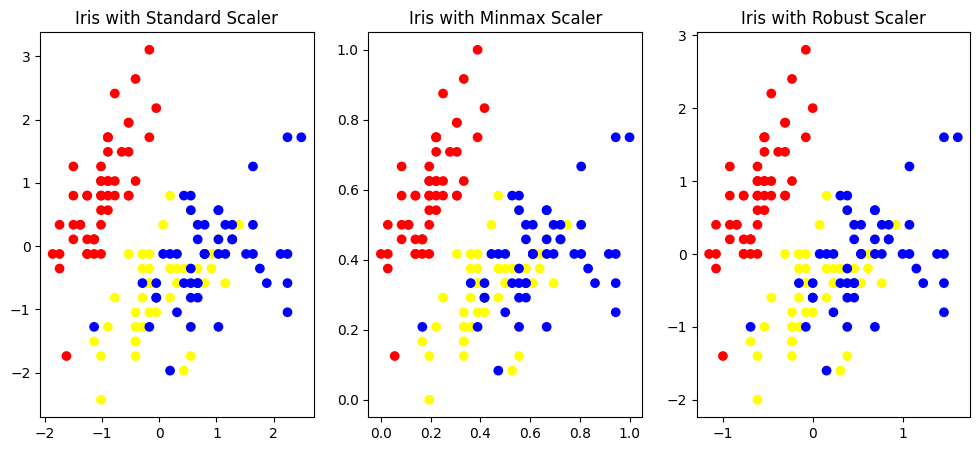

In [10]:
# Displaying the two features of the Scaled Iris
colors=np.array(['red','yellow','blue'])
plt.figure(figsize=(12,5))
plt.subplot(131); plt.title('Iris with Standard Scaler')
plt.scatter(X_iris_stsc[:,0],X_iris_stsc[:,1],c=colors[ys])
plt.subplot(132); plt.title('Iris with Minmax Scaler')
plt.scatter(X_iris_mmsc[:,0],X_iris_mmsc[:,1],c=colors[ys])
plt.subplot(133); plt.title('Iris with Robust Scaler')
plt.scatter(X_iris_rbsc[:,0],X_iris_rbsc[:,1],c=colors[ys])
plt.show()

In [11]:
# Checking that mean and variance with standard scaler go to zero and one, respectively
print('='*12,'Standard Scaler for Iris dataset:')
print('Means of features (all zeros):')
print(np.mean(X_iris_stsc,axis=0))
print('-'*12,'\nVariances of features (all ones):')
print(np.var(X_iris_stsc,axis=0,ddof=1))

============ Standard Scaler for Iris dataset:
Means of features (all zeros):
[-5.68434189e-16 -6.15803704e-16  1.89478063e-16 -1.89478063e-16]
------------ 
Variances of features (all ones):
[1. 1. 1. 1.]
